In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
df = pd.read_csv('archive\monthly_beer_production_in_australia.csv')
df['Month'] = pd.to_datetime(df['Month'])
month = df['Month']
df.set_index('Month', inplace=True)

# df['Month'] = df['Month'].dt.strftime('%Y-%m')

df

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0


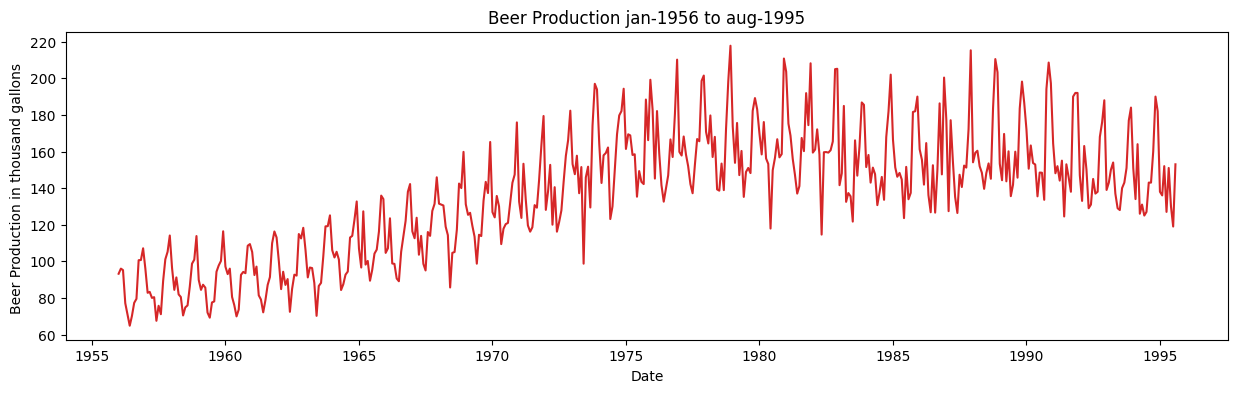

In [3]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Beer Production in thousand gallons ', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

plot_df(df, x=month, y=df['Monthly beer production'], title='Beer Production jan-1956 to aug-1995')

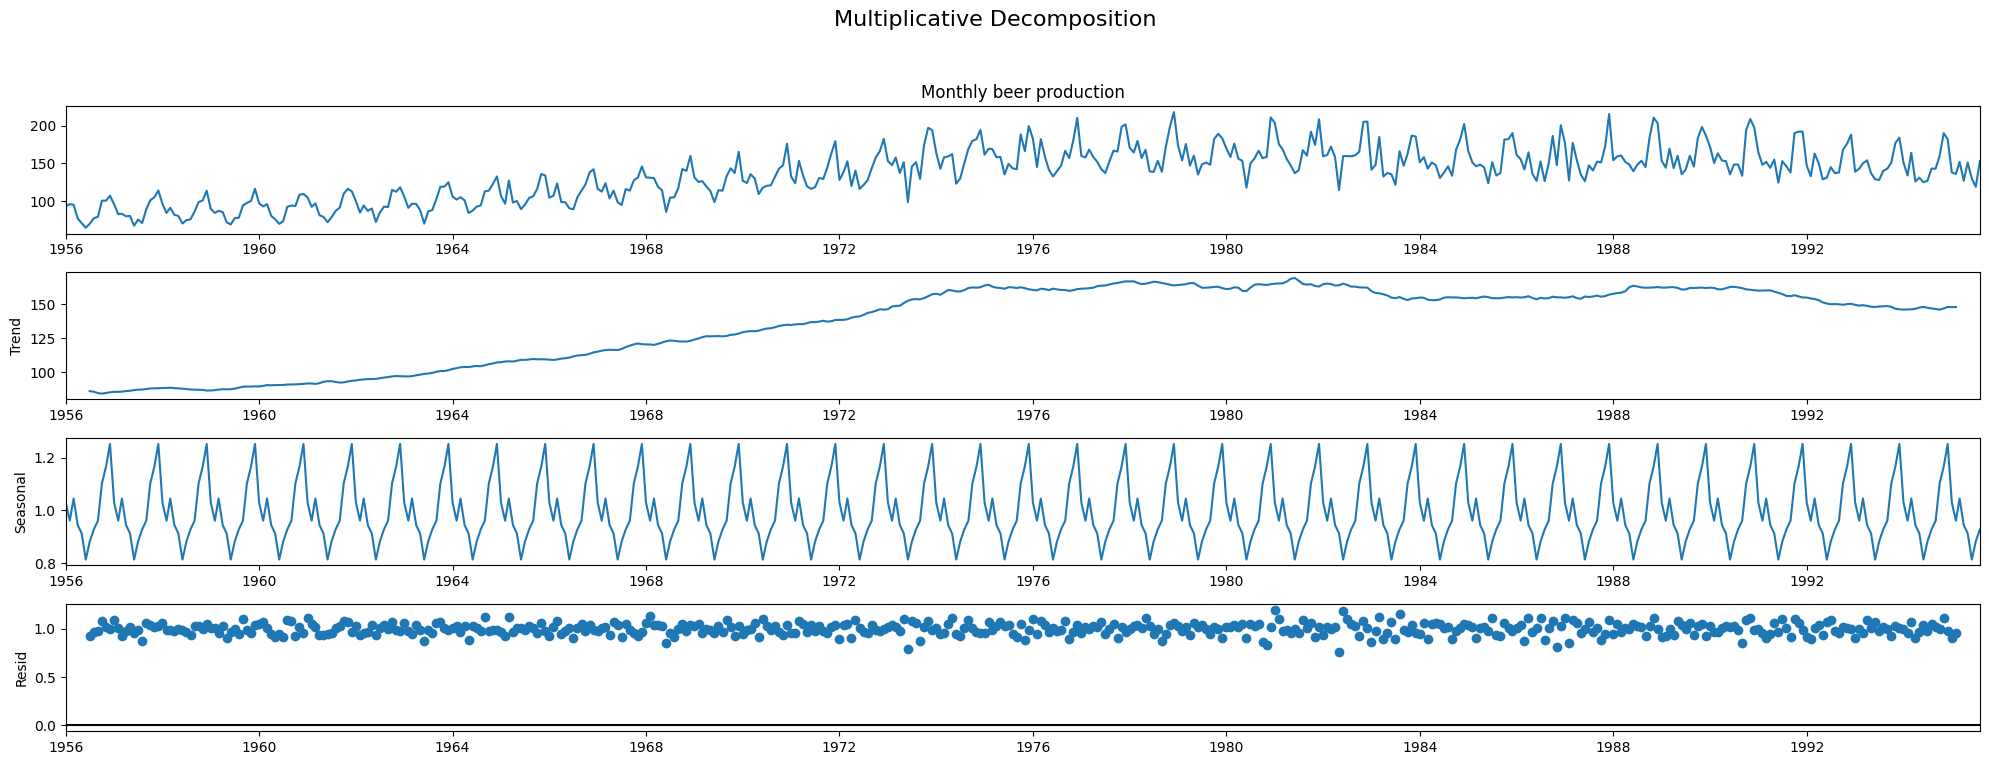

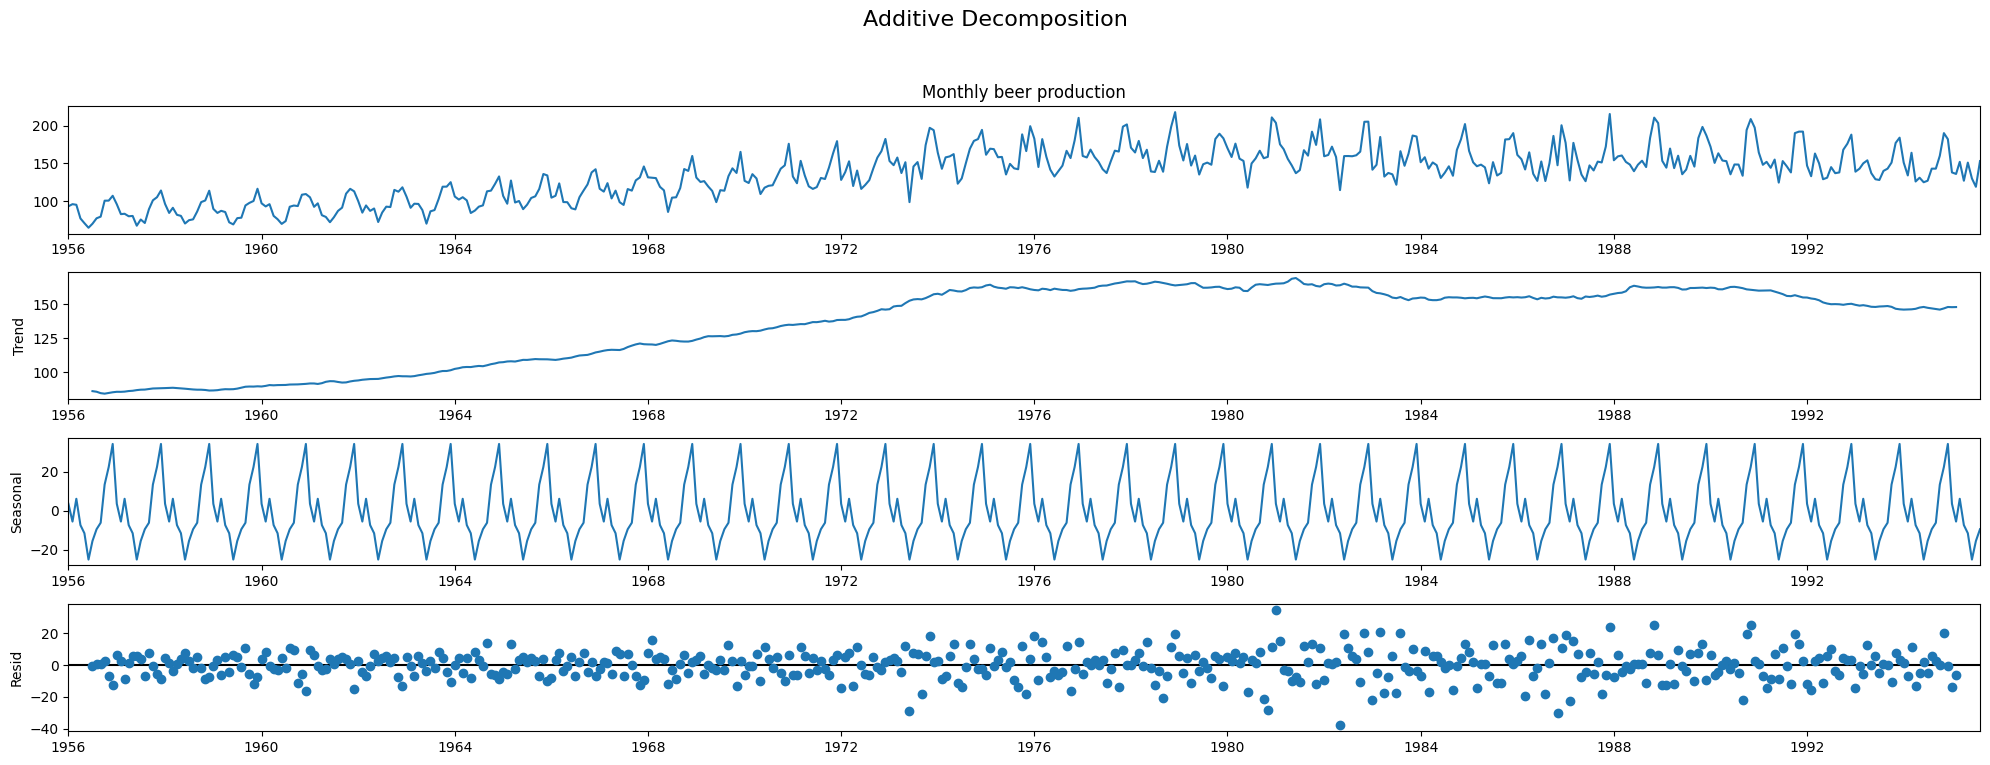

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df['Monthly beer production'], model='multiplicative', period=12)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df['Monthly beer production'], model='additive', period=12)

# Plot
plt.rcParams.update({'figure.figsize': (20,8)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

# ADF Test to Check Stationarity

<h4>H0: It is non-stationary
H1: It is stationary<h4>
We will be considering the null hypothesis that data is not stationary and the alternate hypothesis that data is stationary.

In [5]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(x):
    result=adfuller(x)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['Monthly beer production'])

ADF Test Statistic : -2.282661418787573
p-value : 0.17762099829132627
#Lags Used : 17
Number of Observations : 458
weak evidence against null hypothesis,indicating it is non-stationary 


differencing


In [6]:
df['First Difference'] = df['Monthly beer production'] - df['Monthly beer production'].shift(1)
df

,Monthly beer production,First Difference
Month,,
1956-01-01,93.2,NaN
1956-02-01,96.0,2.8
1956-03-01,95.2,-0.8
1956-04-01,77.1,-18.1
1956-05-01,70.9,-6.2
...,...,...
1995-04-01,127.0,-25.0
1995-05-01,151.0,24.0
1995-06-01,130.0,-21.0


In [7]:
adfuller_test(df['First Difference'].dropna())

ADF Test Statistic : -4.9806637430647465
p-value : 2.4234117859965543e-05
#Lags Used : 18
Number of Observations : 456
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<h4>so now we have d=1 for Arima(p,d,q)i.e no. of integrated differences
    now for p and q we need to check acf and pacf plots<h4>

# ACF and PACF plots

C:\Users\Tareq\OneDrive\Desktop\DS_PBL\env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


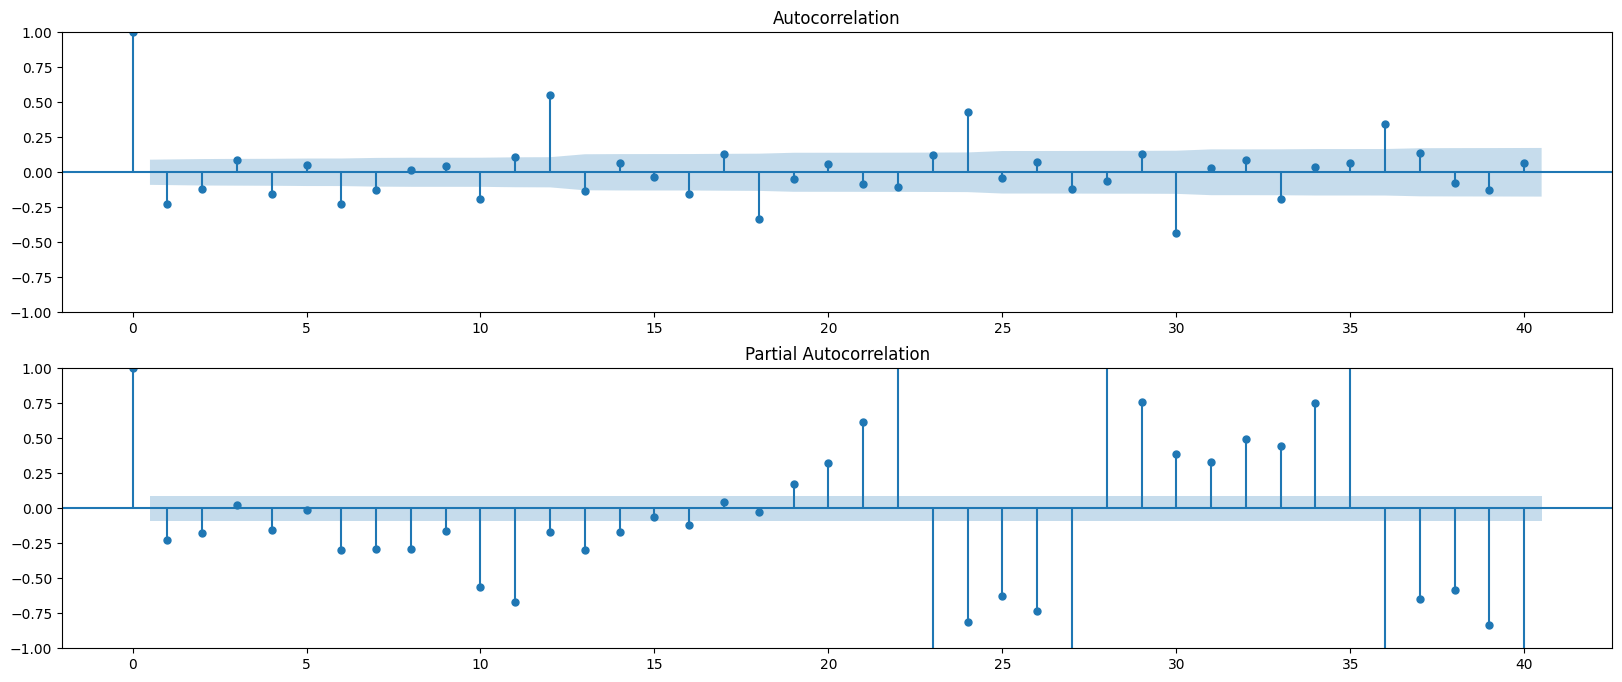

In [8]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['First Difference'].dropna(),lags=40,ax=ax2)


# finding p by PACF

order Here we can see that the first lag is significantly out of the limit and the second one is also out of the significant limit but it is not that far so we can select the order of the p as 2. 



# finding q by ACF

. Here we can see that 1 of the lags are out of the significance limit so we can say that the optimal value of our q (MA) is 1.


# Trend Elements
### There are three trend elements that require configuration.

##### They are the same as the ARIMA model; specifically:

p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.
##### Seasonal Elements
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.

#### ARIMA(p,d,q)(P,D,Q)m
where m = number of observations per year
##### therefore order = 
ARIMA(2,1,1)(2,1,1)12

C:\Users\Tareq\OneDrive\Desktop\DS_PBL\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Tareq\OneDrive\Desktop\DS_PBL\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Month'>

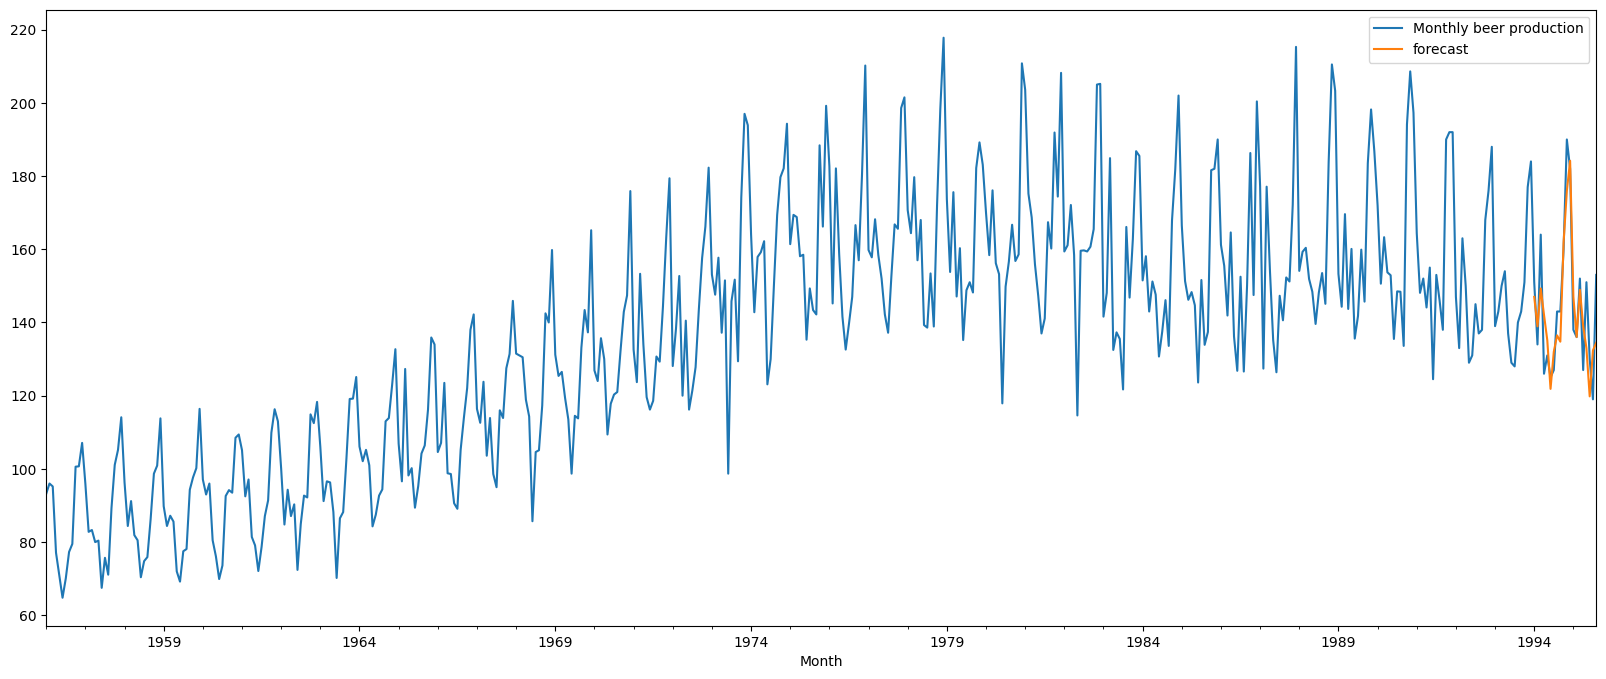

In [9]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Monthly beer production'],order=(2, 1, 1),seasonal_order=(2,1,1,12))
results=model.fit()
start_date = pd.to_datetime("1994-01")
end_date = pd.to_datetime("1995-08")

df['forecast'] = results.predict(start=start_date, end=end_date, dynamic=True,freq = 12)
df[['Monthly beer production','forecast']].plot(figsize=(20,8))

<Axes: >

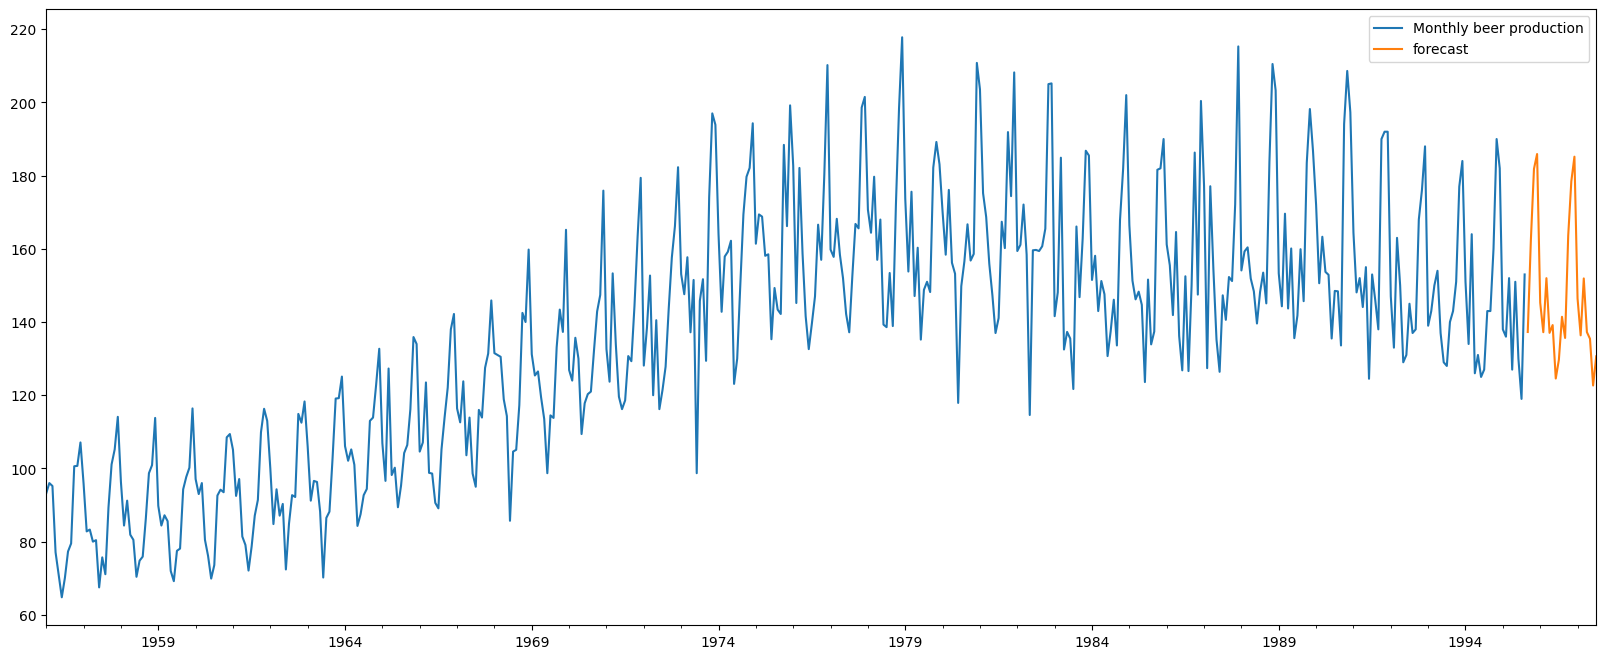

In [10]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])

start_date = pd.to_datetime("1995-09")
end_date = pd.to_datetime("1997-09")

future_df['forecast'] = results.predict(start = start_date, end = end_date, dynamic= True)
future_df[['Monthly beer production', 'forecast']].plot(figsize=(20, 8))


In [11]:

def get_prediction(year, month):
    predicted_values = future_df['forecast'].tail(23)
    return (predicted_values[pd.to_datetime(f"{year}-{month}-01")])


In [12]:
get_prediction(1997,2)

136.36393509740566